#### Regression Project - Energy Production Prediction

In [ ]:
#!pip install tpot

In [2]:
#Importing the Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib 

#Model
import statsmodels.formula.api as smf 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

#AutoML TPot
from tpot import TPOTRegressor

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,KFold

import warnings
warnings.filterwarnings("ignore")  #--to ignore warnings


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### EDA

In [3]:
#Loading the Dataset
df = pd.read_csv("energy_production.csv", delimiter = ";")
#Dropping first row as it contains duplicate header names
df.drop([0],axis=0,inplace = True)
df.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.3,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75,463.58
5,23.63,60.93,1006.41,83.06,439.9


In [4]:
#Checking For NA Values
df.isnull().sum()

temperature          0
exhaust_vacuum       0
amb_pressure         0
r_humidity           0
energy_production    0
dtype: int64

Inference: There are No NA Values present in the Dataset

In [5]:
#Checking the shape of the Dataset
df.shape

(9567, 5)

Inference: There are Total 9567 rows & 5 columns

In [6]:
#Checking Dtype of Variables
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9567 entries, 1 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   temperature        9567 non-null   object
 1   exhaust_vacuum     9567 non-null   object
 2   amb_pressure       9567 non-null   object
 3   r_humidity         9567 non-null   object
 4   energy_production  9567 non-null   object
dtypes: object(5)
memory usage: 448.5+ KB


Inference: All the Variables are of object type will convert them to integer type

In [7]:
#DType Conversion
df['temperature'] = pd.to_numeric(df['temperature'],errors='coerce') #--pd.to_numberic converts to interger
df['exhaust_vacuum'] = pd.to_numeric(df['exhaust_vacuum'],errors='coerce')
df['amb_pressure'] = pd.to_numeric(df['amb_pressure'],errors='coerce')
df['r_humidity'] = pd.to_numeric(df['r_humidity'],errors='coerce')
df['energy_production'] = pd.to_numeric(df['energy_production'],errors='coerce')

Inference: Now the DTypes is been changed, will now check the visualization

#### Visualization

##### Checking for Outliers Using Boxplots

Text(0.5, 1.0, 'R Humidity')

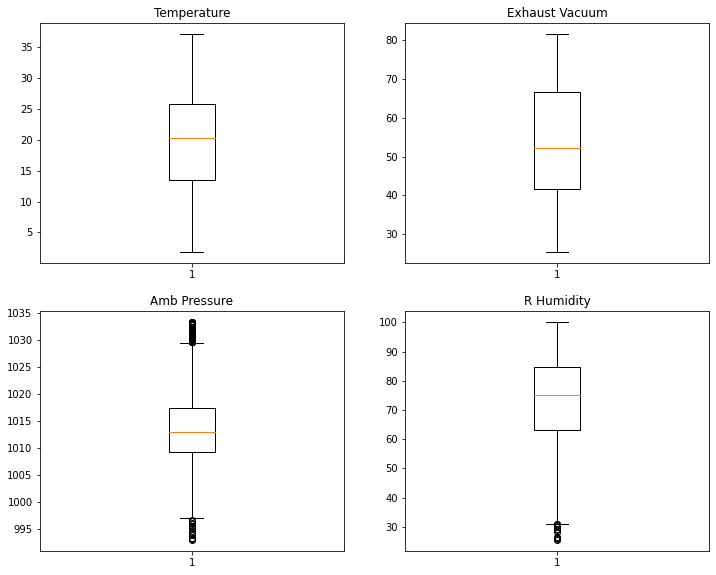

In [8]:
#BoxPlot
plt.figure(figsize=(12,15))
plt.subplot(321)
plt.boxplot(df['temperature'])
plt.title("Temperature")

plt.subplot(322)
plt.boxplot(df['exhaust_vacuum'])
plt.title("Exhaust Vacuum")

plt.subplot(323)
plt.boxplot(df['amb_pressure'])
plt.title("Amb Pressure")

plt.subplot(324)
plt.boxplot(df['r_humidity'])
plt.title("R Humidity")

Inference: So we can see there are outliers in "amb_pressure" & "r_humidity", so will handle them by using the descriptive stats IQR Method

In [9]:
#Descriptive Stats
df.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9567.000000,9567.000000,9567.000000,9567.000000,9567.000000
mean,19.652283,54.307450,1013.258686,73.310359,454.362194
std,7.452153,12.707537,5.938970,14.600407,17.065665
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.335000,439.750000
50%,20.350000,52.080000,1012.940000,74.980000,451.520000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [10]:
# Calculating IQR 
IQR_amb = 1017.26 - 1009.10
IQR_r = 84.83 - 63.335
#printing
print("IQR for amb_pressure is: ",IQR_amb)
print("IQR for r_humidity is: ",IQR_r)

#Calculating Lower & Upper Extreme for amb_pressure
LE_amb = 1009.10 - IQR_amb * 1.5
UE_amb = 1017.26 + IQR_amb * 1.5
#printing
print("Lower Extreme of amb_pressure is: ",LE_amb)
print("Upper Extreme of amb_pressure is: ",UE_amb)

#Calculating Lower & Upper Extreme for r_humidity
LE_r = 63.335 - IQR_r * 1.5
UE_r = 81.56 + IQR_r * 1.5
#printing
print("Lower Extreme of r_humidity is: ",LE_r)
print("Upper Extreme of r_humidity is: ",UE_r)

IQR for amb_pressure is:  8.159999999999968
IQR for r_humidity is:  21.494999999999997
Lower Extreme of amb_pressure is:  996.8600000000001
Upper Extreme of amb_pressure is:  1029.5
Lower Extreme of r_humidity is:  31.09250000000001
Upper Extreme of r_humidity is:  113.8025


##### Outliers Removal using The Lower & Extreme Values (IQR)

In [11]:
#Original shape Before Outlier removal
df.shape

(9567, 5)

In [12]:
# Checking Total Outliers for Lower Extreme of amb_pressure
len(df[df.amb_pressure<LE_amb])

15

In [13]:
#Removing Outliers of amb_pressure 
df1 = df[~(df.amb_pressure<LE_amb)]
df1.shape

(9552, 5)

In [14]:
# Checking Total Outliers for Upper Extreme of amb_pressure
len(df1[df1.amb_pressure>UE_amb])

73

In [15]:
#Removing Outliers of amb_pressure 
df2 = df1[~(df1.amb_pressure>UE_amb)]
df2.shape

(9479, 5)

In [16]:
# Checking Total Outliers for Lower Extreme of r_humidity
len(df2[df2.r_humidity<LE_r])

12

In [17]:
#Removing Outliers of r_humidity
df3 = df2[~(df2.r_humidity<LE_r)]
df3.shape

(9467, 5)

Text(0.5, 1.0, 'R Humidity')

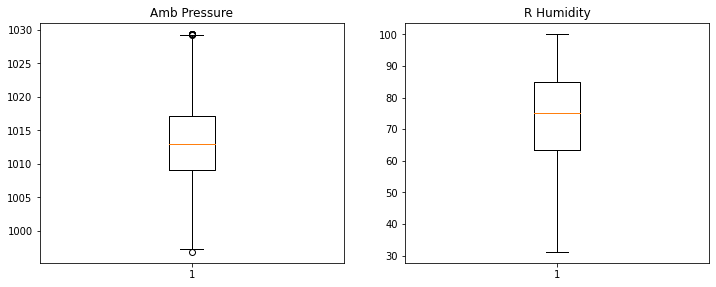

In [18]:
#BoxPlot After Outliers Removal 
plt.figure(figsize=(12,15))

plt.subplot(321)
plt.boxplot(df3['amb_pressure'])
plt.title("Amb Pressure")

plt.subplot(322)
plt.boxplot(df3['r_humidity'])
plt.title("R Humidity")

Inference: Now we only have outliers in amb_pressure variable will remove them again using IQR

In [19]:
#Descriptive Stats 
df3.describe()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
count,9467.000000,9467.000000,9467.000000,9467.000000,9467.000000
mean,19.720953,54.415365,1013.148394,73.323479,454.206436
std,7.426974,12.701035,5.704787,14.551337,17.027908
min,1.810000,25.360000,996.870000,31.150000,420.260000
25%,13.580000,41.740000,1009.090000,63.300000,439.695000
50%,20.500000,52.720000,1012.900000,74.980000,451.210000
75%,25.760000,66.540000,1017.170000,84.840000,468.185000
max,37.110000,81.560000,1029.410000,100.160000,495.760000


In [20]:
# Calculating IQR 
IQR = 1017.17 - 1009.09
#printing
print("IQR for amb_pressure is: ",IQR)

#Calculating Lower & Upper Extreme for amb_pressure
LE = 1009.09 - IQR * 1.5
UE = 1017.17 + IQR * 1.5
#printing
print("Lower Extreme of amb_pressure is: ",LE)
print("Upper Extreme of amb_pressure is: ",UE)

IQR for amb_pressure is:  8.079999999999927
Lower Extreme of amb_pressure is:  996.9700000000001
Upper Extreme of amb_pressure is:  1029.29


In [21]:
# Checking Total Outliers for Lower Extreme of amb_pressure
len(df3[df3.amb_pressure<LE])

1

In [22]:
#Removing Outliers of amb_pressure 
df4 = df3[~(df3.amb_pressure<LE)]
df4.shape

(9466, 5)

In [23]:
# Checking Total Outliers for Upper Extreme of amb_pressure
len(df4[df4.amb_pressure>UE])

6

In [24]:
#Removing Outliers of amb_pressure 
df5 = df4[~(df4.amb_pressure>UE)]
df5.shape

(9460, 5)

Text(0.5, 1.0, 'Amb Pressure')

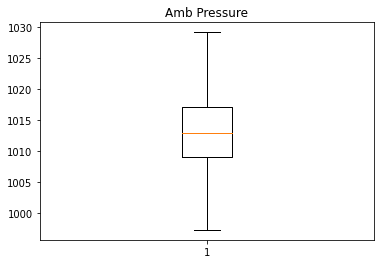

In [25]:
#BoxPlot After Outliers Removal 
plt.boxplot(df5['amb_pressure'])
plt.title("Amb Pressure")

Inference: Now we can See there are No Outliers present in the Dataset According to statstical concepts

##### Checking For Normal Distribution (Histogram)

Text(0.5, 1.0, 'R Humidity')

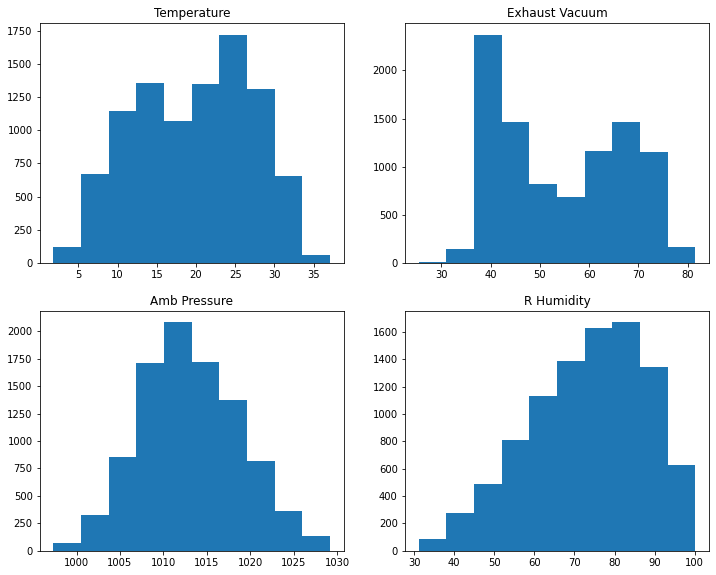

In [26]:
#Histogram 
plt.figure(figsize=(12,15))
plt.subplot(321)
plt.hist(df5['temperature'])
plt.title("Temperature")

plt.subplot(322)
plt.hist(df5['exhaust_vacuum'])
plt.title("Exhaust Vacuum")

plt.subplot(323)
plt.hist(df5['amb_pressure'])
plt.title("Amb Pressure")

plt.subplot(324)
plt.hist(df5['r_humidity'])
plt.title("R Humidity")


Infernce: The 4 Dependent variable does not have proper normal distribution, but for now can consider it as somewhat normally distributed

##### Final Dataset after EDA

In [27]:
# Dataset After EDA
df5.head()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
1,12.04,42.34,1019.72,94.67,465.36
2,13.87,45.08,1024.42,81.69,465.48
3,13.72,54.30,1017.89,79.08,467.05
4,15.14,49.64,1023.78,75.00,463.58
5,23.63,60.93,1006.41,83.06,439.90


#### Detecting Collinearity
Correlation Matrix -- using this method to get a overlook of collinearity present in the dataset

In [28]:
#corr()
df5.corr()

,temperature,exhaust_vacuum,amb_pressure,r_humidity,energy_production
temperature,1.000000,0.842700,-0.508590,-0.542383,-0.947482
exhaust_vacuum,0.842700,1.000000,-0.415344,-0.310376,-0.868671
amb_pressure,-0.508590,-0.415344,1.000000,0.105283,0.521162
r_humidity,-0.542383,-0.310376,0.105283,1.000000,0.388245
energy_production,-0.947482,-0.868671,0.521162,0.388245,1.000000


Inference: As we can see "temperature" & "exhaust_vaccum" have a strong positve Correlation, So can suggest there is a multicollinearity effect present, will now Cross Check with VIF

#### VIF(Variable inflation Factor) -- Using this method to confirm Collinearity if it is still there or not.
Checking all Y(input) Variable one by one regressing them with Eachother

Industry Standard ≤ 20 for VIF Value

In [29]:
#Checking VIF
rsq_Tem = smf.ols('temperature~exhaust_vacuum+amb_pressure+r_humidity',data=df5).fit().rsquared  
vif_Tem = 1/(1-rsq_Tem) 

rsq_ex = smf.ols('exhaust_vacuum~temperature+amb_pressure+r_humidity',data=df5).fit().rsquared  
vif_ex = 1/(1-rsq_ex) 

rsq_amb = smf.ols('amb_pressure~temperature+exhaust_vacuum+r_humidity',data=df5).fit().rsquared  
vif_amb = 1/(1-rsq_amb) 

rsq_rh = smf.ols('r_humidity~temperature+exhaust_vacuum+amb_pressure',data=df5).fit().rsquared  
vif_rh = 1/(1-rsq_rh) 

# Storing vif values in a data frame
d1 = {'Variables':['temperature','exhaust_vacuum','amb_pressure','r_humidity'],'VIF':[vif_Tem,vif_ex,vif_amb,vif_rh]}
Vif_frame = pd.DataFrame(d1)  
Vif_frame

,Variables,VIF
0,temperature,5.907042
1,exhaust_vacuum,3.906507
2,amb_pressure,1.447229
3,r_humidity,1.697335


inference: There are no collinearity between variables Since All columns VIF is less then 20. So Now We will Start the Model Building 

#### Model Building

In [30]:
#Final Dataset Shape
df5.shape

(9460, 5)

In [31]:
#Splitting X & Y Variable
# X Vaiable
X = df5.drop(['energy_production'], axis = 'columns')
# Y Variable
Y = df5.energy_production
#printing shape of both
print("X :",X.shape)
print("Y :",len(Y))

X : (9460, 4)
Y : 9460


In [32]:
# Train & Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

##### Linear model

In [33]:
#Model
Lmodel = LinearRegression()
Lmodel.fit(X_train,Y_train)
Lmodel.score(X_test,Y_test)*100

93.05337315619025

##### Model Validation - KFold

In [34]:
#Kfold of Linear model
kfold = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, Y, cv=kfold)

array([0.92878396, 0.93412571, 0.92379733, 0.9265859 , 0.92676023])

Inference: We can see that in 5 iterations we get a score above 90% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose

##### Find best Algorithms using GridSearchCV

In [35]:
#GridSearchCV

def find_best_model_using_gridsearchcv(x,y):
    algos = {
        'linear_regression' :{'model': LinearRegression(),'params':{'normalize': [False]}
        },
        'ridge': {'model': Ridge(),'params': { 'alpha': [0.1,0.1,0.5,1]}
        },
        'lasso': {'model': Lasso(),'params': {'alpha': [0.1,0.5,1],'selection': ['random', 'cyclic']}
        },
        'decision_tree': {'model': DecisionTreeRegressor(),'params': {'criterion' : ['mse', 'friedman_mse'],'splitter': ['best','random']}
        },
        'Random Forest': {'model': RandomForestRegressor(),'params': {'n_estimators' : [100,125,150,200],'max_features': [3,4]}
        },
        'XGBoost': {'model': XGBRegressor(),'params': {'n_estimators' : [100,125,150,200,225,250],'max_depth': [3,4,5],'learning_rate':[0.1,0.2]}
        },
        'SVM': {'model': SVR(),'params': {'kernel' :['rbf']}
        },
        'KNN': {'model': KNeighborsRegressor(),'params': {'n_neighbors':[5,10,15,20,25,30,35,40,45,50]}
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=10)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv)
        gs.fit(x,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,Y)

,model,best_score,best_params
0,linear_regression,0.928975,{'normalize': False}
1,ridge,0.928975,{'alpha': 0.1}
2,lasso,0.928951,"{'alpha': 0.1, 'selection': 'cyclic'}"
3,decision_tree,0.931478,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
4,Random Forest,0.963400,"{'max_features': 3, 'n_estimators': 150}"
5,XGBoost,0.967485,"{'learning_rate': 0.2, 'max_depth': 5, 'n_esti..."
6,SVM,0.373678,{'kernel': 'rbf'}
7,KNN,0.946493,{'n_neighbors': 5}


Inference: From this GridSearch it Seems XGBoost has the Same Best Accuracy,Will Confirm it through AutoML once more and Built the Final Model

#### AutoML 

In [36]:
#TPot
tpot = TPOTRegressor(generations=10,population_size=50,verbosity=2,random_state=10,n_jobs=-1)
tpot.fit(X_train,Y_train)

Optimization Progress:   0%|          | 0/550 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -13.382969463437917

Generation 2 - Current best internal CV score: -12.410430626523638

Generation 3 - Current best internal CV score: -12.100961648773978

Generation 4 - Current best internal CV score: -11.574644605727116

Generation 5 - Current best internal CV score: -11.574644605727116

Generation 6 - Current best internal CV score: -11.481524238910456

Generation 7 - Current best internal CV score: -11.007626659727094

Generation 8 - Current best internal CV score: -11.007626659727094

Generation 9 - Current best internal CV score: -10.925426094140349

Generation 10 - Current best internal CV score: -10.352312700361495

Best pipeline: XGBRegressor(SelectPercentile(RidgeCV(input_matrix), percentile=99), learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6500000000000001, verbosity=0)


TPOTRegressor(generations=10, n_jobs=-1, population_size=50, random_state=10,
              verbosity=2)

In [37]:
print(tpot.score(X_test,Y_test))

-9.751933502280638


Inference: So the tpot Also Gave XGBoost as the best algorithms for this Dataset so, XGBoost will be our Final Model.

#### Final Model

In [41]:
#Final Model (Going with Grid Parameters)
F_model = XGBRegressor(n_estimators=250,learning_rate=0.2, max_depth=5)
F_model.fit(X_train,Y_train)
F_model.score(X_test,Y_test)*100

96.89750270187429

#### Saving the Trained Model

In [ ]:
# .sav file
import pickle
filename = 'Energy_Prediction.sav'
pickle.dump(F_model, open(filename, 'wb'))

In [ ]:
# .pickle file
with open('Energy_Predictions.pickle','wb') as f:
    pickle.dump(F_model,f)